In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from sko.GA import RCGA

from src.train import train_neural_network_bp, prepare_data
from src.load_data import load_data_climate_change, create_lag_features
from src.draw import draw_neural_network

In [19]:
"""
Parâmetros
"""

# Ordem do modelo
LAG_FEATURES = 5

# Max Número de neurônios na camada oculta
MAX_HIDDEN_NEURONS = 50

# Algoritmo Evolutivo
EA_SIZE_POP = 8
EA_MAX_ITER = 20
EA_PROB_MUT = 0.08
EA_PROB_CROS = 0.9

# PSO
PSO_NUM_PARTICLES = 100
PSO_MAX_ITER = 300
PSO_w = 0.7
PSO_c1 = 1.5
PSO_c2 = 2
PSO_NUM_RUNS = 5

CSV file found locally.
Loading CSV file...
Dataset loaded
Preprocessing data...


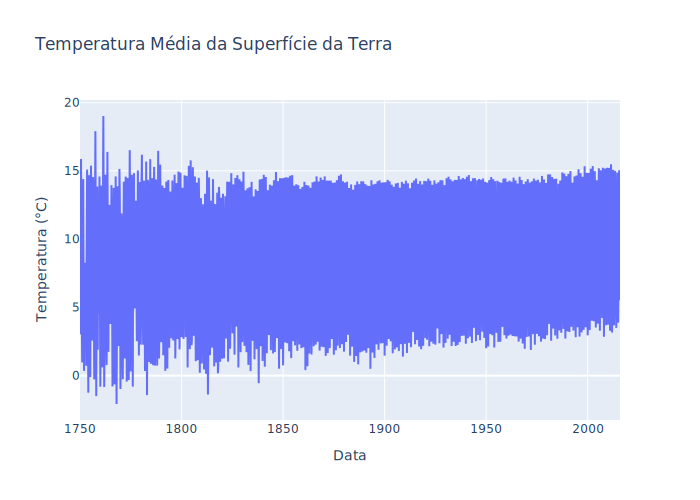

In [20]:
"""
Criando a Série Temporal
"""

ts = load_data_climate_change()

fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=ts["dt"], y=ts["LandAverageTemperature"], mode="lines", name="Temperatura"
    )
)

fig.update_layout(
    title="Temperatura Média da Superfície da Terra",
    xaxis_title="Data",
    yaxis_title="Temperatura (°C)",
)
fig.show("svg")

In [21]:
"""
Escolhendo o numero de lag features (ordem do modelo)
"""

ts_with_lags = create_lag_features(ts, LAG_FEATURES, targets=["LandAverageTemperature"])
ts_with_lags.head()

,dt,LandAverageTemperature,LandAverageTemperature_lag_1,LandAverageTemperature_lag_2,LandAverageTemperature_lag_3,LandAverageTemperature_lag_4,LandAverageTemperature_lag_5
5,1750-06-01,12.937,3.034,3.083,5.626,8.490,11.573
6,1750-07-01,15.868,3.083,5.626,8.490,11.573,12.937
7,1750-08-01,14.750,5.626,8.490,11.573,12.937,15.868
8,1750-09-01,11.413,8.490,11.573,12.937,15.868,14.750
9,1750-10-01,6.367,11.573,12.937,15.868,14.750,11.413


In [5]:
"""
Preparando split de treino e teste
"""

X_train, y_train, X_test, y_test = prepare_data(ts_with_lags, column="LandAverageTemperature")

Percent of data in training set: 80.00%
Percent of data in test set: 20.00%
Standardizing features...
Standardization complete.


In [24]:
"""
Usando o GA para otimizar o número de neurônios na camada oculta e a taxa de aprendizado

O indivíduo é uma lista com 4 elementos:
    - 1º elemento: número de neurônios na camada oculta (dezena)
    - 2º elemento: número de neurônios na camada oculta (unidade)
    - 3º elemento: taxa de aprendizado (primeiro dígito)
    - 4º elemento: taxa de aprendizado (segundo dígito)
A taxa de aprendizado é obtida com a formula:
    0.001 + (individual[2] * 10 + individual[3]) * (0.01 - 0.001) / 99
"""


def evaluate(individual):
    return train_neural_network_bp(
        individual, X_train, y_train, X_test, y_test, MAX_HIDDEN_NEURONS
    )


# RCGA is a real-coded genetic algorithm
ga = RCGA(
    func=evaluate,
    n_dim=4,
    size_pop=EA_SIZE_POP,
    max_iter=EA_MAX_ITER,
    prob_mut=EA_PROB_MUT,
    prob_cros=EA_PROB_CROS,
    lb=[0] * 4,
    ub=[9] * 4,
)

# Run the GA optimization
best_individual, best_rmse = ga.run()

print(f"Best individual: {best_individual}")
print(f"Best RMSE: {best_rmse}")

Best individual: [8.40071868 7.35126982 6.49491111 8.5904181 ]
Best RMSE: [0.62531948]


In [23]:
"""
Curva de convergência
"""

fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=list(range(ga.max_iter)),
        y=ga.generation_best_Y,
        mode="lines+markers",
        name="Best Fitness",
    )
)
fig.update_layout(
    title="Best Fitness over Generations",
    xaxis_title="Generation",
    yaxis_title="Best Fitness",
)
fig.show()

In [8]:
"""
Salvando os resultados
"""

import os

if not os.path.exists("results"):
    os.makedirs("results")

if not os.path.exists("results/GA"):
    os.makedirs("results/GA")

pd.DataFrame({"rmse": ga.generation_best_Y, "iteration": range(ga.max_iter)}).to_csv(
    f"results/GA/ga_climate_change_{LAG_FEATURES}.csv", index=False
)

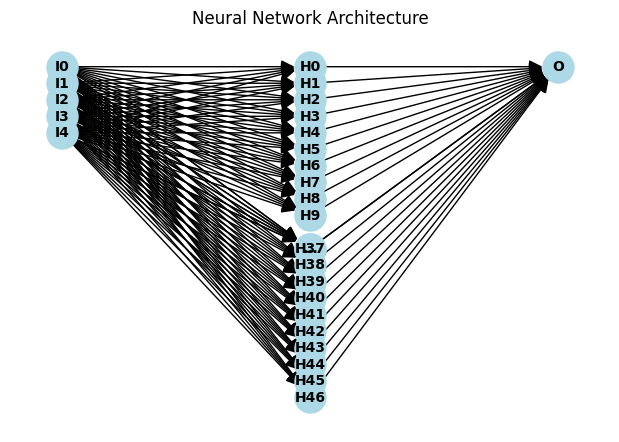

Network parameters:
Input size: 5
Hidden size: 47
Output size: 1
Learning rate: 0.0071818181818181824
Number of parameters: 330


In [25]:
"""
Configurações da melhor rede neural
"""

ind = best_individual.astype(int)
best_learning_rate_init = 0.001 + (ind[2] * 10 + ind[3]) * (0.01 - 0.001) / 99
best_learning_rate_init = min(max(best_learning_rate_init, 0.001), 0.01)
best_hidden_neurons = (
    int(MAX_HIDDEN_NEURONS * (best_individual[0] * 10 + best_individual[1]) / 99) + 1
)

input_size = X_train.shape[1]
output_size = 1
draw_neural_network(
    X_train.shape[1], best_hidden_neurons, output_size=output_size, show_hidden=10
)
print("Network parameters:")
print(f"Input size: {input_size}")
print(f"Hidden size: {best_hidden_neurons}")
print(f"Output size: {output_size}")
print(f"Learning rate: {best_learning_rate_init}")
print(
    f"Number of parameters: {input_size * best_hidden_neurons + best_hidden_neurons + best_hidden_neurons * output_size + output_size}"
)

Best hidden neurons: 29
Best learning rate: 0.0029090909090909093
Final RMSE: 0.7406673055837207


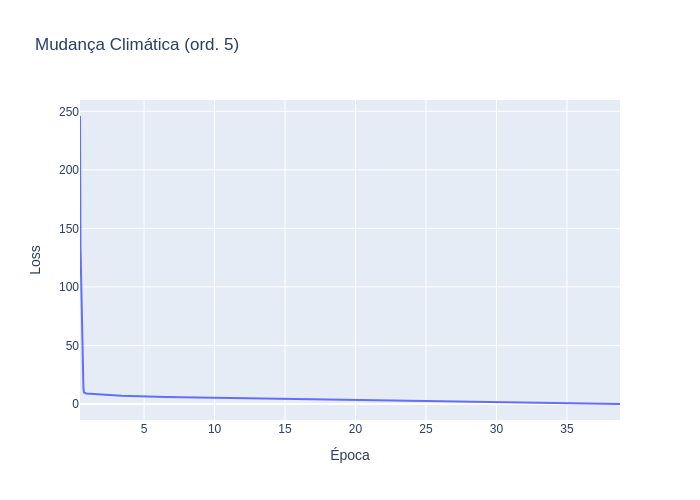

Final loss: 0.4551297571353024


In [10]:
"""
Treinando novamente a melhor rede neural, para observar a curva de perda
"""

from sklearn.neural_network import MLPRegressor
from sklearn.metrics import root_mean_squared_error

print(f"Best hidden neurons: {best_hidden_neurons}")
print(f"Best learning rate: {best_learning_rate_init}")

best_mlp = MLPRegressor(
    hidden_layer_sizes=(best_hidden_neurons,),
    learning_rate_init=best_learning_rate_init,
    random_state=1234,
    max_iter=1000,
)

best_mlp.fit(X_train, y_train)

# Evaluate the final model
final_predictions = best_mlp.predict(X_test)
final_rmse = root_mean_squared_error(y_test, final_predictions)
print(f"Final RMSE: {final_rmse}")

# Loss chart
fig = go.Figure()
fig.add_trace(go.Scatter(x=best_mlp.loss_curve_, mode="lines", name="Loss"))
fig.update_layout(
    title="Mudança Climática (ord. 5)", xaxis_title="Época", yaxis_title="Loss"
)
fig.show("png")
print(f"Final loss: {best_mlp.loss_}")

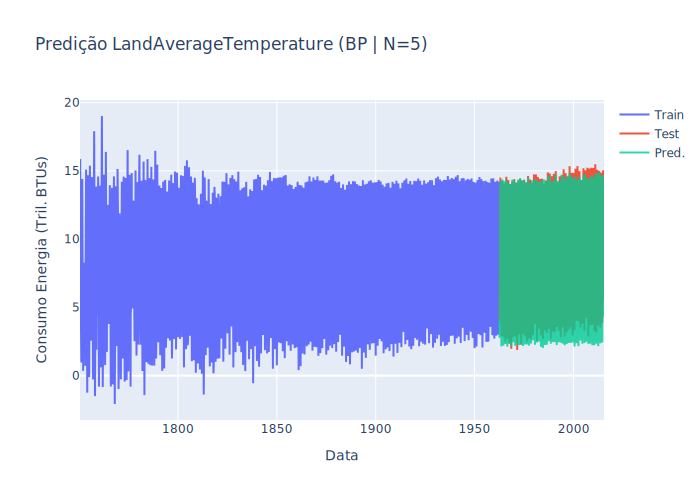

In [11]:
"""
Visualizando a predição da Rede com Backpropagation
"""

X = ts_with_lags.drop(["dt", "LandAverageTemperature"], axis=1)
y = ts_with_lags["LandAverageTemperature"]

X_plot_train = pd.DataFrame(X_train, columns=X.columns)
X_plot_train["dt"] = ts_with_lags[ts_with_lags.index < X_plot_train.shape[0]]["dt"]
X_plot_train["LandAverageTemperature"] = y_train

X_plot_test = pd.DataFrame(X_test, columns=X.columns)
X_plot_test["dt"] = ts_with_lags[ts_with_lags.index >= X_plot_train.shape[0]][
    "dt"
].reset_index(drop=True)
X_plot_test["LandAverageTemperature"] = y_test.reset_index(drop=True)

fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=X_plot_train["dt"],
        y=X_plot_train["LandAverageTemperature"],
        mode="lines",
        name="Train",
        opacity=1,
    )
)
fig.add_trace(
    go.Scatter(
        x=X_plot_test["dt"],
        y=X_plot_test["LandAverageTemperature"],
        mode="lines",
        name="Test",
        opacity=1,
    )
)
fig.add_trace(
    go.Scatter(
        x=X_plot_test["dt"],
        y=final_predictions,
        mode="lines",
        name="Pred.",
        opacity=0.8,
    )
)
fig.update_layout(
    title=f"Predição LandAverageTemperature (BP | N={LAG_FEATURES})",
    yaxis_title="Consumo Energia (Tril. BTUs)",
    xaxis_title="Data",
)
fig.show("svg")

In [12]:
from src.pso import NeuralNetwork, PSO, fitness

In [13]:
network = NeuralNetwork(LAG_FEATURES, best_hidden_neurons, output_size=1)

In [14]:
pso_histories = []
pso_best_rmse = 1e9
pso_best_weights = None

for i in range(PSO_NUM_RUNS):
    print(f"Run {i + 1} of {PSO_NUM_RUNS}")
    pso = PSO(
        network,
        X_train,
        y_train,
        num_particles=PSO_NUM_PARTICLES,
        max_iter=PSO_MAX_ITER,
        w=PSO_w,
        c1=PSO_c1,
        c2=PSO_c2,
    )
    pso.optimize()
    pso_histories.append(pso.history)
    if pso.best_weights_fitness < pso_best_rmse:
        pso_best_rmse = pso.best_weights_fitness
        pso_best_weights = pso.best_weights
    print()

print(f"Best RMSE: {pso_best_rmse}")

"""
Salvando os resultados
"""
if not os.path.exists("results/PSO"):
    os.makedirs("results/PSO")

pd.DataFrame(
    {"rmse": pso_histories[0], "iteration": range(len(pso_histories[0]))}
).to_csv(f"results/PSO/pso_climate_change_{LAG_FEATURES}.csv", index=False)

Run 1 of 5
Iteration 300/300 - RMSE: 1.3087896852512495
Run 2 of 5
Iteration 300/300 - RMSE: 1.2997316293314152
Run 3 of 5
Iteration 300/300 - RMSE: 1.3925990292090966
Run 4 of 5
Iteration 300/300 - RMSE: 1.4132934545802258
Run 5 of 5
Iteration 300/300 - RMSE: 1.2598347050494288
Best RMSE: 1.259834705049428


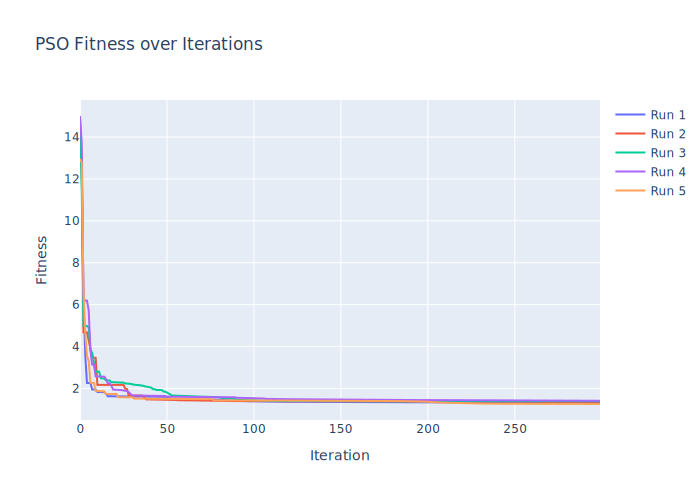

In [15]:
fig = go.Figure()

for i, history in enumerate(pso_histories):
    fig.add_trace(
        go.Scatter(
            x=list(range(len(history))), y=history, mode="lines", name=f"Run {i + 1}"
        )
    )

fig.update_layout(
    title="PSO Fitness over Iterations", xaxis_title="Iteration", yaxis_title="Fitness"
)
fig.show("svg")

In [16]:
"""
Configurações da melhor rede neural
"""

best_network = NeuralNetwork(LAG_FEATURES, best_hidden_neurons, output_size=1)
best_network.set_weights(pso.best_weights)
print("Train RMSE:", fitness(best_network, X_train, y_train))

Train RMSE: 1.259834705049428


In [17]:
y_pred = np.array([best_network.predict(phi) for phi in X_test])
rmse = root_mean_squared_error(y_test, y_pred)
print(f"Test RMSE: {rmse:.4f}")

Test RMSE: 1.0451


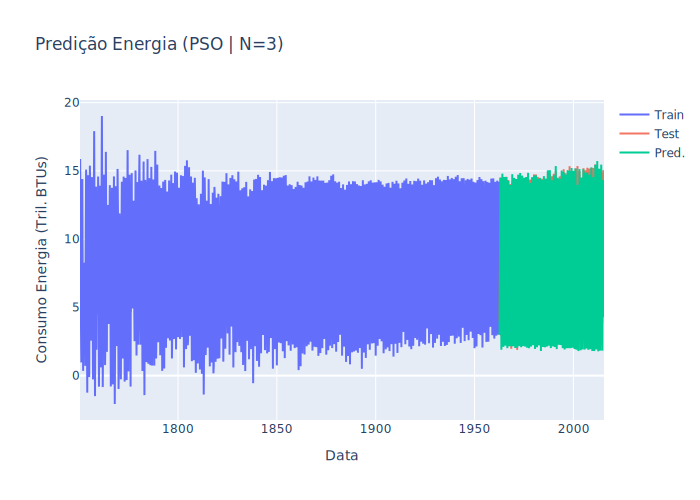

In [18]:
"""
Visualizando a predição da Rede com PSO
"""

X_plot_train = pd.DataFrame(X_train, columns=X.columns)
X_plot_train["dt"] = ts_with_lags[ts_with_lags.index < X_plot_train.shape[0]]["dt"]
X_plot_train["Total Climate Change"] = y_train

X_plot_test = pd.DataFrame(X_test, columns=X.columns)
X_plot_test["dt"] = ts_with_lags[ts_with_lags.index >= X_plot_train.shape[0]][
    "dt"
].reset_index(drop=True)
X_plot_test["Total Climate Change"] = y_test.reset_index(drop=True)

fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=X_plot_train["dt"],
        y=X_plot_train["Total Climate Change"],
        mode="lines",
        name="Train",
    )
)
fig.add_trace(
    go.Scatter(
        x=X_plot_test["dt"],
        y=X_plot_test["Total Climate Change"],
        mode="lines",
        name="Test",
        opacity=0.8,
    )
)
fig.add_trace(
    go.Scatter(
        x=X_plot_test["dt"], y=pd.Series(y_pred.flatten()), mode="lines", name="Pred."
    )
)
fig.update_layout(
    title="Predição Energia (PSO | N=3)",
    yaxis_title="Consumo Energia (Tril. BTUs)",
    xaxis_title="Data",
)
fig.show("svg")